In [2]:
import numpy as np
from numba import jit
from numpy.random import default_rng as rg
rng = rg(12345)
from tqdm import tqdm
import sys
sys.path.append('../core')
%matplotlib inline

In [3]:
import torch
torch.manual_seed(0)
import torch.optim as optim

In [4]:
from FLDojo import dojo
from FL import FL
from display import*

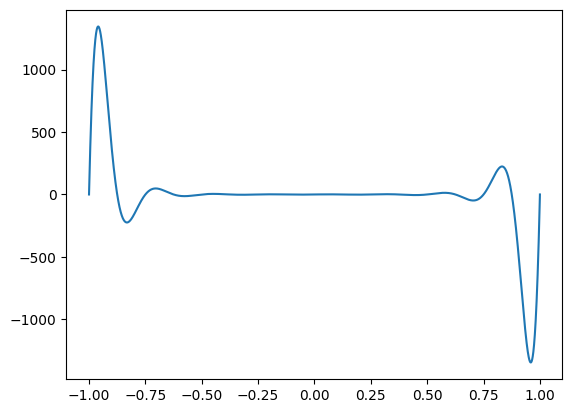

In [5]:
Xs = np.linspace(-1,1,40000)
Ys = np.sin(Xs*8*np.pi)*np.exp(8*Xs**2)
from matplotlib import pyplot as plt
plt.plot(Xs,Ys)
# a three layer nn can represent any multivariate function (continuous or discontinuous) https://arxiv.org/abs/2012.03016


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
p = np.random.permutation(len(Xs))
Xs = Xs[p]
Ys = Ys[p]
X = torch.from_numpy(Xs).float().unsqueeze(1).to(device)
y = torch.from_numpy(Ys).float().unsqueeze(1).to(device)
split = 0.75
train_X = X[:int(split*len(X))]
train_y = y[:int(split*len(y))]
test_X = X[int(split*len(X)):]
test_y = y[int(split*len(y)):]

In [7]:
D = dojo()
D.epochs=1000
D.max_batch_size=train_X.shape[0]
opt = lambda x: optim.Adam(x, lr=0.00005) # Adam better than SGD and AdamW in quick tests.

100%|██████████| 1000/1000 [00:08<00:00, 115.55it/s]


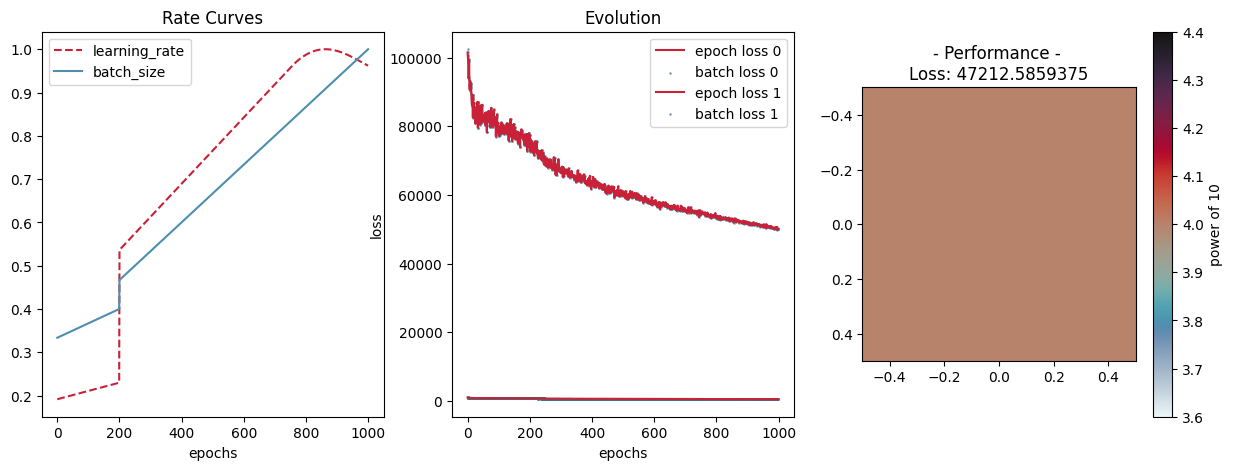

In [8]:
sizes = [1, 100] # larger the size, the better the approximation (shallow better than deep)
delta = np.array([1]*len(sizes))*0.05
k = [0.9]*len(sizes) # smaller k seems to help slightly, but not much.
# with torch.autograd.set_detect_anomaly(True):
net = FL(device, sizes, delta, k, opttype=opt, bias=True) # expect 1.6% error rate
report = D.train(net, train_X, train_y, start_batch_size=10000, minibatch=0.5)
ecran(net, test_X, test_y, torch.nn.MSELoss(), report, classification=False)

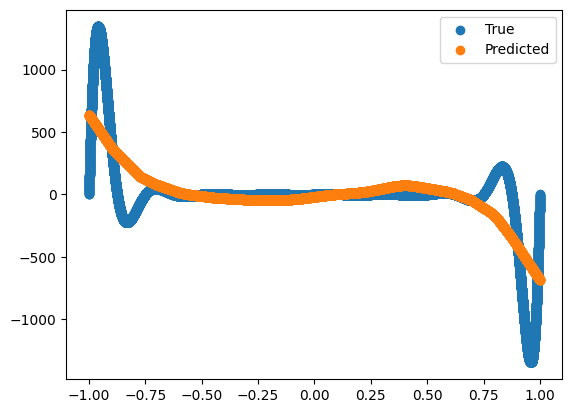

In [10]:
plt.scatter(Xs,Ys,label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()